In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from pryngles import *
from pryngles import pixx
import time
extension="pixx"
#extension="cpixx"
import multiprocessing as mp
import os,sys,glob

# Import local functions
import extra_func as efunc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
orbit_i = 90#30
ring_i = 0#60
ring_l = 0
gamma, beta_obs, lamb_obs, lamb_star = Util.calcStartingPosition(orbit_i,ring_i,ring_l)

pixx_sys = System()
s=pixx_sys.add(kind="Star",physics=dict(radius=Consts.rsun/pixx_sys.ul),optics=dict(limb_coeffs=[0.65]))
p=pixx_sys.add(kind="Planet", primary=s, 
               radius=Consts.rsaturn/pixx_sys.ul,
               orbit=dict(a=1, e=0.0),
               physics=dict(radius=Consts.rsaturn/pixx_sys.ul),
               optics=dict(nspangles=5000))
r=pixx_sys.add(kind="Ring", primary=p,
               physics=dict(fi=1.5, fe=2.25, i=gamma),
               optics=dict(nspangles=10000))

#fou_gasplanet_optical_50.dat , fou_lambert.dat
RP=pixx_sys.ensamble_system(extension=extension, 
                            fname_planet="./fou_files/Planet/fou_bmsca60.0_asurf1.0.dat",
                            fname_ring="./fou_files/Ring/fou_ring_0_4_0_8_40gaus.dat")
RP.behavior["interp_method_ring"] = "bilinear"

print(RP.fname_ring)
print(RP.nmugsr)
print(RP.behavior)

./fou_files/Ring/fou_ring_0_4_0_8_40gaus.dat
41
{'shadows': True, 'interp_method_planet': 'spline', 'interp_method_ring': 'bilinear'}


In [4]:
lamb_initial = lamb_star
lamb_final = lamb_initial + 360*Consts.deg
lambs = np.linspace(lamb_initial,lamb_final,361)

# Initialise the starting position
RP.changeObserver([lamb_obs,beta_obs])
RP.changeStellarPosition(lamb_initial)
RP._updateGeometricalFactors()
RP._updateIncomingStellarFlux()
RP._updateObservedFacetAreas()
    
Stot  = []
Sp    = []
Sr    = []
Ptot  = []
Pp    = []
Pr    = []
alpha = []

for lamb in lambs:
    RP.changeStellarPosition(lamb)
    print("True anomaly: ", (lamb-lamb_initial)/Consts.deg)
    RP._updateGeometricalFactors()
    RP._updateIncomingStellarFlux()
    RP._updateObservedFacetAreas()
    RP.updateReflection()

    # Save the relevant data
    Stot  += [RP.Stot]
    Sp    += [RP.Stotp]
    Sr    += [RP.Stotr]
    Ptot  += [RP.Ptot]
    Pp    += [RP.Ptotp]
    Pr    += [RP.Ptotr]
    alpha += [np.arccos(RP.alphaps)/Consts.deg]
    
true_anomaly = list((lambs-lamb_initial)/Consts.deg)    
save_dict = {"lambda": true_anomaly, "alpha": alpha, "Stot": Stot,
             "Sp": Sp, "Sr": Sr, "Ptot": Ptot, "Pp": Pp, "Pr": Pr}

#Pickle the data, if file already exists it will be overwritten
with open("/home/allard/Data/Gauss_test/standard_system_40gauss_points_bilinear_new.pkl", "wb") as f:
    pickle.dump(save_dict, f)
    
Stot = np.array(Stot)
Sp = np.array(Sp)
Sr = np.array(Sr)
Ptot = np.array(Ptot)
Pp = np.array(Pp)
Pr = np.array(Pr)

True anomaly:  0.0
True anomaly:  1.0000000000000013
True anomaly:  2.0000000000000027
True anomaly:  3.000000000000004
True anomaly:  4.000000000000005
True anomaly:  4.999999999999995
True anomaly:  5.999999999999996
True anomaly:  6.999999999999997
True anomaly:  7.999999999999998
True anomaly:  9.0
True anomaly:  10.000000000000002
True anomaly:  11.000000000000002
True anomaly:  12.000000000000004
True anomaly:  13.000000000000005
True anomaly:  14.000000000000007
True anomaly:  14.999999999999995
True anomaly:  15.999999999999996
True anomaly:  16.999999999999996
True anomaly:  18.0
True anomaly:  19.0
True anomaly:  20.000000000000004
True anomaly:  21.000000000000004
True anomaly:  21.999999999999993
True anomaly:  23.000000000000007
True anomaly:  23.999999999999996
True anomaly:  24.999999999999996
True anomaly:  25.999999999999996
True anomaly:  27.0
True anomaly:  28.0
True anomaly:  29.000000000000004
True anomaly:  30.000000000000004
True anomaly:  30.999999999999993
True

True anomaly:  357.0
True anomaly:  358.0
True anomaly:  359.0
True anomaly:  360.0


<IPython.core.display.Javascript object>


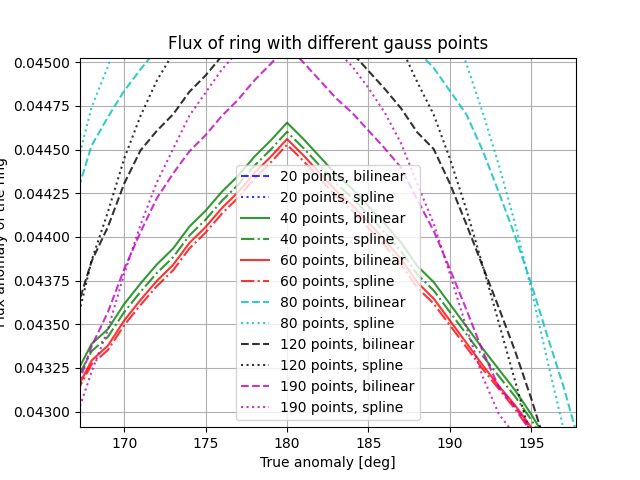

<IPython.core.display.Javascript object>


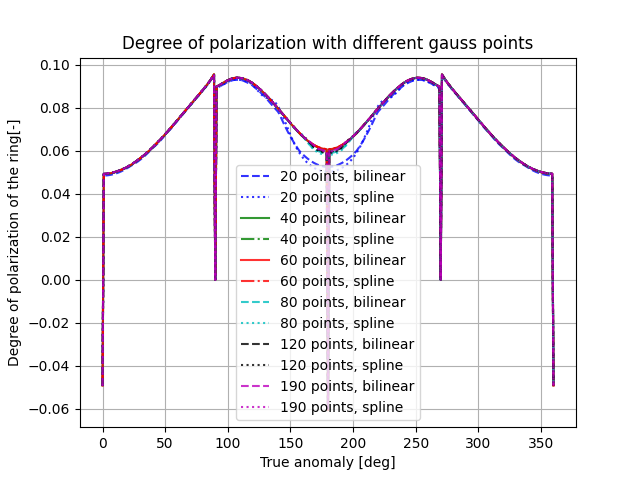

<IPython.core.display.Javascript object>


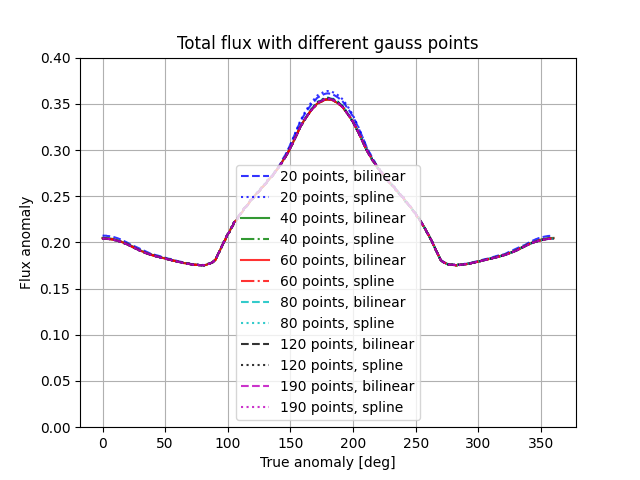

<IPython.core.display.Javascript object>


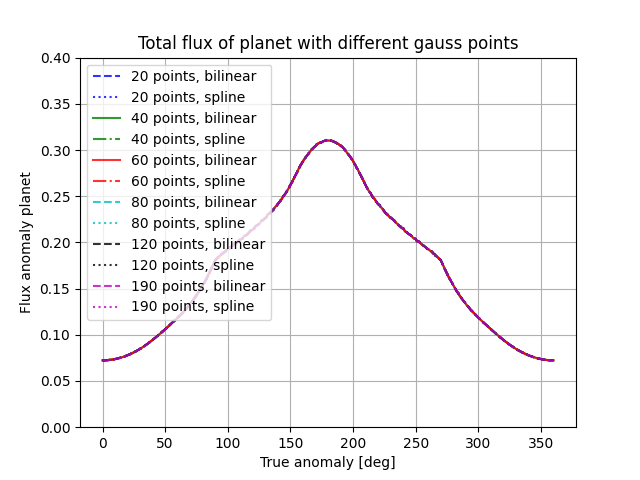

In [6]:
nums = np.array([20,40,60,80,120,190])
names = np.array(["_bilinear","_spline"])
colors = np.array(['b','g','r','c','k','m'])
fig1=plt.figure()
ax1=fig1.gca()

fig2=plt.figure()
ax2=fig2.gca()

fig3=plt.figure()
ax3=fig3.gca()

fig4=plt.figure()
ax4=fig4.gca()

for ii,num in enumerate(nums):
    for jj,name in enumerate(names):
        if ii == 1 or ii == 2:
            data_name = f"/home/allard/Data/Gauss_test/standard_system_{num}gauss_points{name}_new.pkl"
        else:
            data_name = f"/home/allard/Data/Gauss_test/standard_system_{num}gauss_points{name}.pkl"
        with open(data_name,"rb") as f:
            save_file = pickle.load(f)

        true_anomaly = np.array(save_file["lambda"])
        alpha = np.array(save_file["alpha"])
        Stot = np.array(save_file["Stot"])
        Sp = np.array(save_file["Sp"])
        Sr = np.array(save_file["Sr"])
        Ptot = np.array(save_file["Ptot"])
        Pp = np.array(save_file["Pp"])
        Pr = np.array(save_file["Pr"])
        
        if jj == 0:
            if ii == 1 or ii == 2:
                ax1.plot(true_anomaly,Sr[:,0],'-',color=colors[ii],label=f"{num} points, {name[1:]}",alpha=0.8)
                ax2.plot(true_anomaly,Pr,'-',color=colors[ii],label=f"{num} points, {name[1:]}",alpha=0.8)
                ax3.plot(true_anomaly,Stot[:,0],'-',color=colors[ii],label=f"{num} points, {name[1:]}",alpha=0.8)
                ax4.plot(true_anomaly,Sp[:,0],'-',color=colors[ii],label=f"{num} points, {name[1:]}",alpha=0.8)
            else:
                ax1.plot(true_anomaly,Sr[:,0],'--',color=colors[ii],label=f"{num} points, {name[1:]}",alpha=0.8)
                ax2.plot(true_anomaly,Pr,'--',color=colors[ii],label=f"{num} points, {name[1:]}",alpha=0.8)
                ax3.plot(true_anomaly,Stot[:,0],'--',color=colors[ii],label=f"{num} points, {name[1:]}",alpha=0.8)
                ax4.plot(true_anomaly,Sp[:,0],'--',color=colors[ii],label=f"{num} points, {name[1:]}",alpha=0.8)
        else:
            if ii == 1 or ii == 2:
                ax1.plot(true_anomaly,Sr[:,0],'-.',color=colors[ii],label=f"{num} points, {name[1:]}",alpha=0.8)
                ax2.plot(true_anomaly,Pr,'-.',color=colors[ii],label=f"{num} points, {name[1:]}",alpha=0.8)
                ax3.plot(true_anomaly,Stot[:,0],'-.',color=colors[ii],label=f"{num} points, {name[1:]}",alpha=0.8)
                ax4.plot(true_anomaly,Sp[:,0],'-.',color=colors[ii],label=f"{num} points, {name[1:]}",alpha=0.8)
            else:
                ax1.plot(true_anomaly,Sr[:,0],':',color=colors[ii],label=f"{num} points, {name[1:]}",alpha=0.8)
                ax2.plot(true_anomaly,Pr,':',color=colors[ii],label=f"{num} points, {name[1:]}",alpha=0.8)
                ax3.plot(true_anomaly,Stot[:,0],':',color=colors[ii],label=f"{num} points, {name[1:]}",alpha=0.8)
                ax4.plot(true_anomaly,Sp[:,0],':',color=colors[ii],label=f"{num} points, {name[1:]}",alpha=0.8)

ax1.set_xlabel("True anomaly [deg]")
ax1.set_ylabel("Flux anomaly of the ring")
ax1.set_title("Flux of ring with different gauss points")
ax1.legend()
ax1.grid()

ax2.set_xlabel("True anomaly [deg]")
ax2.set_ylabel("Degree of polarization of the ring[-]")
ax2.set_title("Degree of polarization with different gauss points")
ax2.legend()
ax2.grid()

ax3.set_ylim([0,0.4])
ax3.set_xlabel("True anomaly [deg]")
ax3.set_ylabel("Flux anomaly")
ax3.set_title("Total flux with different gauss points")
ax3.legend()
ax3.grid()

ax4.set_ylim([0,0.4])
ax4.set_xlabel("True anomaly [deg]")
ax4.set_ylabel("Flux anomaly planet")
ax4.set_title("Total flux of planet with different gauss points")
ax4.legend()
ax4.grid()

plt.show()

<IPython.core.display.Javascript object>


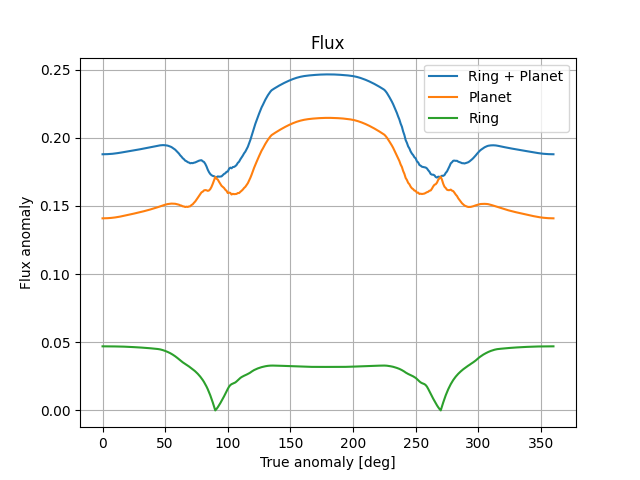

<IPython.core.display.Javascript object>


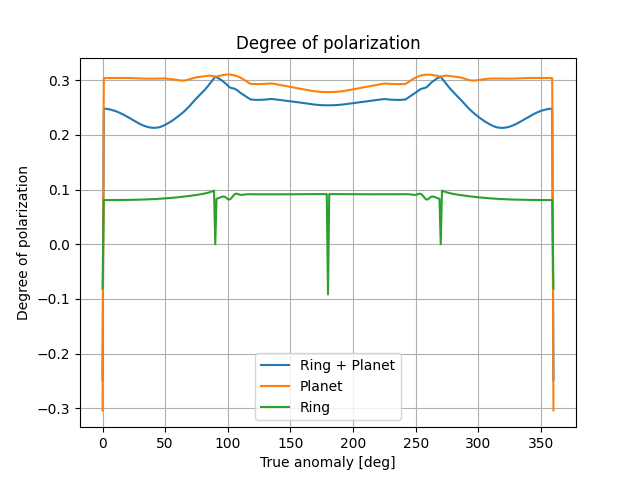

In [23]:
data_name = f"/home/allard/Data/Gauss_test/new_system_20gauss_points.pkl"
with open(data_name,"rb") as f:
    save_file = pickle.load(f)

true_anomaly = np.array(save_file["lambda"])
alpha = np.array(save_file["alpha"])
Stot = np.array(save_file["Stot"])
Sp = np.array(save_file["Sp"])
Sr = np.array(save_file["Sr"])
Ptot = np.array(save_file["Ptot"])
Pp = np.array(save_file["Pp"])
Pr = np.array(save_file["Pr"])

fig1=plt.figure()
ax1=fig1.gca()
ax1.plot(true_anomaly,Stot[:,0],label="Ring + Planet")
ax1.plot(true_anomaly,Sp[:,0],label="Planet")
ax1.plot(true_anomaly,Sr[:,0],label="Ring")
ax1.set_xlabel("True anomaly [deg]")
ax1.set_ylabel("Flux anomaly")
ax1.set_title("Flux")
ax1.legend()
ax1.grid()
plt.show()

fig1=plt.figure()
ax1=fig1.gca()
ax1.plot(true_anomaly,Ptot,label="Ring + Planet")
ax1.plot(true_anomaly,Pp,label="Planet")
ax1.plot(true_anomaly,Pr,label="Ring")
ax1.set_xlabel("True anomaly [deg]")
ax1.set_ylabel("Degree of polarization")
ax1.set_title("Degree of polarization")
ax1.legend()
ax1.grid()
plt.show()

## Testing interpolation issues

In [5]:
# extension = "cpixx"
extension = "pixx"
gamma, beta_obs, lamb_obs, lamb_star = Util.calcStartingPosition(90,0,0)

pixx_sys = System()
s=pixx_sys.add(kind="Star",physics=dict(radius=Consts.rsun/pixx_sys.ul),optics=dict(limb_coeffs=[0.65]))
p=pixx_sys.add(kind="Planet", primary=s, 
               radius=Consts.rsaturn/pixx_sys.ul,
               orbit=dict(a=0.05, e=0.0),
               physics=dict(radius=Consts.rsaturn/pixx_sys.ul),
               optics=dict(nspangles=1000))
r=pixx_sys.add(kind="Ring", primary=p,
               physics=dict(fi=1.5, fe=2.25, i=gamma),
               optics=dict(nspangles=2000))

#fou_gasplanet_optical_50.dat , fou_lambert.dat
RP=pixx_sys.ensamble_system(extension=extension, 
                            fname_planet="./fou_files/Planet/fou_bmsca60.0_asurf1.0.dat",
                            fname_ring="./fou_files/Ring/fou_ring_2_0_0_3.dat")
#"./fou_files/Ring/fou_ring_2_0_0_3.dat" "./fou_files/Ring/Mie/fou_file_mie_1.5_080_4500_2.0_0.3_60gaus.dat"
RP.behavior["interp_method_ring"] = "bilinear"#"spline"
if extension == "cpixx":
    print(RP.fname_ring)
    print(RP.SCr.nmugs)
elif extension == "pixx":
    print(RP.fname_ring)
    print(RP.nmugsr)
    
# extension = "pixx"

./fou_files/Ring/fou_ring_2_0_0_3.dat
41


In [13]:
lamb_initial = lamb_star
lamb_final = lamb_initial + 180*Consts.deg
lambs = np.linspace(lamb_initial,lamb_final,361)

# Initialise the starting position
RP.changeObserver([lamb_obs,beta_obs])
RP.changeStellarPosition(lamb_initial)
RP._updateGeometricalFactors()
RP._updateIncomingStellarFlux()
RP._updateObservedFacetAreas()

Stotsave = []
Spsave   = []
Srsave   = []
Ptotsave = []
Ppsave   = []
Prsave   = []
backls   = []
alpha    = []
theta0   = []

for lamb in lambs:
    RP.changeStellarPosition(lamb)
    print("True anomaly: ", (lamb-lamb_initial)/Consts.deg)
    RP._updateGeometricalFactors()
    RP._updateIncomingStellarFlux()
    RP._updateObservedFacetAreas()
    
    Stotp = np.zeros(3)
    Ptotp = 0
    
    #Planet conditions
    condo=(RP.ap)*(RP.ip)

    # Facets that are illuminated through the rings
    condspr = (RP.apsr)*(RP.ips)

    # Facets that are visible but the line of sight is blocked by the rings
    condspo = (RP.apso)*(RP.ip)

    # Facets that are both of the above
    condspb = RP.apsb

    cond = condo + condspr + condspo + condspb

    if cond.sum() > 0:
        if RP.physics["extension"] == "pixx":
            Stokesp = pixx.reflection(cond.sum(),RP.phidiffps[cond],RP.betaps[cond],
                                      abs(RP.etaps[cond]),abs(RP.zetaps[cond]),
                                      RP.nmugsp,RP.nmatp,RP.nfoup,RP.xmup,RP.rfoup,
                                      np.ones(cond.sum())*RP.normp*RP.afp,
                                      RP.behavior["interp_method_planet"]
                                     )
        elif RP.physics["extension"] == "cpixx":
            Stokesp = RP.SCp.calculate_stokes(RP.phidiffps[cond],RP.betaps[cond],
                                              abs(RP.etaps[cond]),abs(RP.zetaps[cond]),
                                              np.ones(cond.sum())*RP.normp*RP.afp
                                             )
        Sp = Stokesp[:,:-1]
        Stotp = np.sum(Sp,axis=0)/(np.pi*RP.Rp**2)
        # Calculate degree of polarization
        if abs(Stotp[0]) < 1e-6:
            Ptotp = 0.0
        elif abs(Stotp[2]) < 1e-6:
            Ptotp = -Stotp[1]/Stotp[0]
        else:
            Ptotp = np.sqrt(Stotp[1]**2 + Stotp[2]**2)/Stotp[0]
            
    back = False 
    if (np.inner(RP.nstar_equ,RP.nr_equ) < 0) ^ (np.inner(RP.nobs_equ,RP.nr_equ) < 0):
        back = True
        
    if back:
        if RP.physics["extension"] == "pixx":
            Stokesr = pixx.reflection(len(RP.phidiffrs), RP.phidiffrs, RP.betars,
                                      abs(RP.etars), abs(RP.zetars),
                                      RP.nmugsr,RP.nmatr,RP.nfour,RP.xmur,RP.tfour,
                                      np.ones(len(RP.phidiffrs))*RP.normr*RP.afr,
                                      RP.behavior["interp_method_ring"]
                                     )
        elif RP.physics["extension"] == "cpixx":
            Stokesr = RP.SCr.calculate_stokes(RP.phidiffrs, RP.betars,
                                              abs(RP.etars), abs(RP.zetars),
                                              np.ones(len(RP.phidiffrs))*RP.normr*RP.afr,
                                              qreflection=0
                                             )
    else:
        if RP.physics["extension"] == "pixx":
            Stokesr = pixx.reflection(len(RP.phidiffrs), RP.phidiffrs, RP.betars,
                                      abs(RP.etars), abs(RP.zetars),
                                      RP.nmugsr,RP.nmatr,RP.nfour,RP.xmur,RP.rfour,
                                      np.ones(len(RP.phidiffrs))*RP.normr*RP.afr,
                                      RP.behavior["interp_method_ring"]
                                     )
        elif RP.physics["extension"] == "cpixx":
            Stokesr = RP.SCr.calculate_stokes(RP.phidiffrs, RP.betars,
                                              abs(RP.etars), abs(RP.zetars),
                                              np.ones(len(RP.phidiffrs))*RP.normr*RP.afr,
                                              qreflection=1
                                             )
    Sr = Stokesr[:,:-1]
    Pir = Stokesr[:,-1]
    Stotr = np.sum(Sr,axis=0)/(np.pi*(RP.Rp**2)) 

    # Calculate degree of polarization
    if abs(Stotr[0]) < 1e-6:
        Ptotr = 0.0
    elif abs(Stotr[2]) < 1e-6:
        Ptotr = -Stotr[1]/Stotr[0]
    else:
        Ptotr = np.sqrt(Stotr[1]**2 + Stotr[2]**2)/Stotr[0]
        
    Stot = Stotp + Stotr
    if abs(Stot[0]) < 1e-6:
        Ptot = 0.0
    elif abs(Stot[2]) < 1e-6:
        Ptot = -Stot[1]/Stot[0]
    else:
        Ptot = np.sqrt(Stot[1]**2 + Stot[2]**2)/Stot[0]
        
    # Save the relevant data
    Stotsave += [Stot]
    Spsave   += [Stotp]
    Srsave   += [Stotr]
    Ptotsave += [Ptot]
    Ppsave   += [Ptotp]
    Prsave   += [Ptotr]
    backls   += [back]
    alpha    += [np.arccos(RP.alphaps)/Consts.deg]
    theta0   += [RP.etars[0]]
    
true_anomaly = list((lambs-lamb_initial)/Consts.deg)    
save_dict = {"lambda": true_anomaly, "alpha": alpha, "Stot": Stotsave,
             "Sp": Spsave, "Sr": Srsave, "Ptot": Ptotsave, "Pp": Ppsave, 
             "Pr": Prsave, "back": backls, "Theta0": theta0}

# Pickle the data, if file already exists it will be overwritten
# with open("/home/allard/Data/Interpolation_test/bilinear_60gauss_points_new_mie.pkl", "wb") as f:
#     pickle.dump(save_dict, f)

True anomaly:  0.0
Star vector:  [ 6.89200322e-08  6.58346103e-16 -1.07516078e+01]
Normal vector ring:  [ 3.20510362e-09  3.20510352e-09 -1.00000000e+00]
[0.99992692 0.99992684 0.99992675 ... 0.99983571 0.99983571 0.99983571]
New incident angle:  [0.69268681 0.69308463 0.6934826  ... 1.03860156 1.03860161 1.03860125]
Min angle, Max angle:  0.6926868070070988 1.0386017512834622
Average angle:  0.8837396313254214
True anomaly:  0.49999999999999434
True anomaly:  1.0000000000000013
True anomaly:  1.4999999999999958
True anomaly:  2.0000000000000027
True anomaly:  2.4999999999999973
True anomaly:  3.000000000000004
True anomaly:  3.4999999999999987
True anomaly:  4.000000000000005
True anomaly:  4.5
True anomaly:  4.999999999999995
True anomaly:  5.500000000000001
True anomaly:  5.999999999999996
True anomaly:  6.500000000000003
True anomaly:  6.999999999999997
True anomaly:  7.500000000000004
True anomaly:  7.999999999999998
True anomaly:  8.500000000000005
True anomaly:  9.0
True anomaly

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


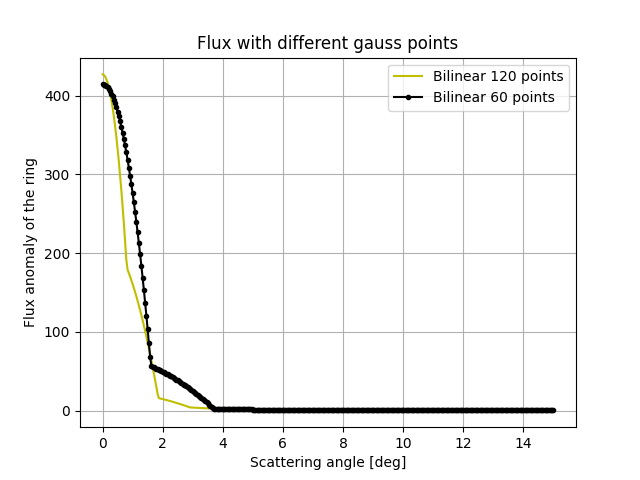

<IPython.core.display.Javascript object>


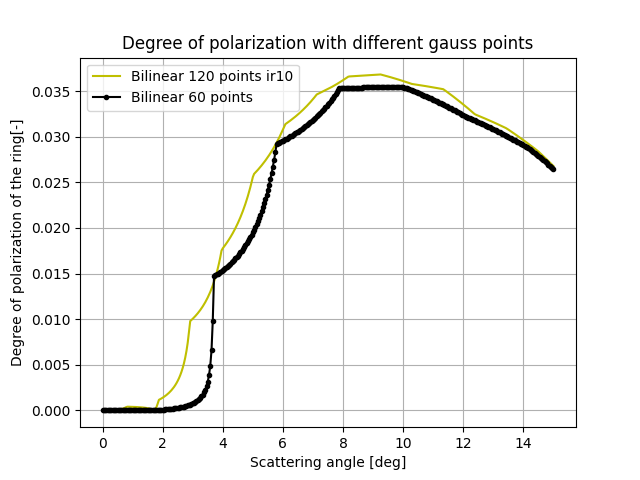

<IPython.core.display.Javascript object>


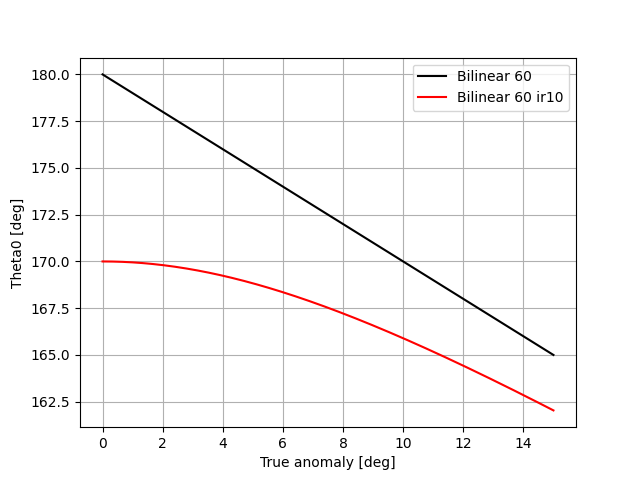

Minimum flux:  0.31226343332584044
Minimum flux:  0.31299695688535545
Minimum flux:  -0.5442355136929915


In [5]:
nums = np.array([20,60,120,190])#np.array([20,40,60,80,120])
names = np.array(["bilinear_","spline_"])
colors = np.array(['b','g','r','c'])
fig1=plt.figure()
ax1=fig1.gca()

fig2=plt.figure()
ax2=fig2.gca()

fig3=plt.figure()
ax3=fig3.gca()
# for jj,name in enumerate(names):
#     for ii,num in enumerate(nums):
#         data_name = f"/home/allard/Data/Interpolation_test/{name}{num}gauss_points.pkl"
#         with open(data_name,"rb") as f:
#             save_file = pickle.load(f)

#         true_anomaly = np.array(save_file["lambda"])
#         alpha = np.array(save_file["alpha"])
#         Sr = np.array(save_file["Sr"])
#         Sp = np.array(save_file["Sp"])
#         Stot = np.array(save_file["Stot"])
#         Pr = np.array(save_file["Pr"])

# #         alpha = np.delete(alpha, 90)
# #         Sr = np.delete(Srfull[:,0], 90)
# #         Pr = np.delete(Pr, 90)
#         if jj == 0:
#             ax1.plot(180-alpha,Sr[:,0],'--',color=colors[ii],label=f"{name[:-1]} {num} points")
#             ax2.plot(180-alpha,Pr,'--',color=colors[ii],label=f"{name[:-1]} {num} points")
# #             ax3.plot(alpha[:180],Sr[:180,0],'--',label=f"{name[:-1]} {num} points Ring",alpha=0.8)
#             ax3.plot(true_anomaly,Sp[:,0],'--',color=colors[ii],label=f"{name[:-1]} {num} points Planet")
#             ax3.plot(true_anomaly,Stot[:,0],'--',color=colors[ii],label=f"{name[:-1]} {num} points Total")
#         else:
#             ax1.plot(180-alpha,Sr[:,0],':',color=colors[ii],label=f"{name[:-1]} {num} points")
#             ax2.plot(180-alpha,Pr,':',color=colors[ii],label=f"{name[:-1]} {num} points")
#             ax3.plot(true_anomaly,Sp[:,0],':',color=colors[ii],label=f"{name[:-1]} {num} points Planet")
#             ax3.plot(true_anomaly,Stot[:,0],':',color=colors[ii],label=f"{name[:-1]} {num} points Total")

data_name = f"/home/allard/Data/Interpolation_test/bilinear_120gauss_points_new_mie_close.pkl"
with open(data_name,"rb") as f:
    save_file = pickle.load(f)

true_anomaly = np.array(save_file["lambda"])
alpha = np.array(save_file["alpha"])
Sr = np.array(save_file["Sr"])
Sp = np.array(save_file["Sp"])
Stot = np.array(save_file["Stot"])
Pr = np.array(save_file["Pr"])
Pflux = np.sqrt(Sr[:,1]**2 + Sr[:,2]**2)

ax1.plot(180-alpha,Sr[:,0],'-',color='y',label=f"Bilinear 120 points")
ax2.plot(180-alpha,abs(Pr),'-',color='y',label=f"Bilinear 120 points ir10")
# ax2.plot(180-alpha,Pflux,'-',color='y',label=f"Bilinear 120 points ir10")
# ax3.plot(true_anomaly,Sp[:,0],'-',color='y',label=f"Bilinear 120 points ir10")
# ax3.plot(true_anomaly,Stot[:,0],'-',color='y',label=f"Bilinear 120 points ir10")
print("Minimum flux: ", np.min(Sr[:,0]))

# data_name = f"/home/allard/Data/Interpolation_test/bilinear_90gauss_points_new_mie_ir10_close.pkl"
# with open(data_name,"rb") as f:
#     save_file = pickle.load(f)

# true_anomaly = np.array(save_file["lambda"])
# alpha = np.array(save_file["alpha"])
# Sr = np.array(save_file["Sr"])
# Sp = np.array(save_file["Sp"])
# Stot = np.array(save_file["Stot"])
# Pr = np.array(save_file["Pr"])
# Pflux = np.sqrt(Sr[:,1]**2 + Sr[:,2]**2)

# ax1.plot(180-alpha,Sr[:,0],'-',color='k',label=f"Bilinear 90 points ir10")
# ax2.plot(180-alpha,abs(Pr),'-',color='k',label=f"Bilinear 90 points ir10")
# # ax2.plot(180-alpha,Pflux,'-',color='k',label=f"Bilinear 90 points ir10")
# ax3.plot(true_anomaly,Sp[:,0],'-',color='k',label=f"Bilinear 90 points ir10")
# ax3.plot(true_anomaly,Stot[:,0],'-',color='k',label=f"Bilinear 90 points ir10")
# print("Minimum flux: ", np.min(Sr[:,0]))

# data_name = f"/home/allard/Data/Interpolation_test/bilinear_80gauss_points_new_mie_ir10_close.pkl"
# with open(data_name,"rb") as f:
#     save_file = pickle.load(f)

# true_anomaly = np.array(save_file["lambda"])
# alpha = np.array(save_file["alpha"])
# Sr = np.array(save_file["Sr"])
# Sp = np.array(save_file["Sp"])
# Stot = np.array(save_file["Stot"])
# Pr = np.array(save_file["Pr"])
# Pflux = np.sqrt(Sr[:,1]**2 + Sr[:,2]**2)

# ax1.plot(180-alpha,Sr[:,0],'-',color='b',label=f"Bilinear 80 points ir10")
# ax2.plot(180-alpha,abs(Pr),'-',color='b',label=f"Bilinear 80 points ir10")
# # ax2.plot(180-alpha,Pflux,'-',color='b',label=f"Bilinear 80 points ir10")
# ax3.plot(true_anomaly,Sp[:,0],'-',color='b',label=f"Bilinear 80 points ir10")
# ax3.plot(true_anomaly,Stot[:,0],'-',color='b',label=f"Bilinear 80 points ir10")
# print("Minimum flux: ", np.min(Sr[:,0]))

# data_name = f"/home/allard/Data/Interpolation_test/bilinear_70gauss_points_new_mie_ir10_close.pkl"
# with open(data_name,"rb") as f:
#     save_file = pickle.load(f)

# true_anomaly = np.array(save_file["lambda"])
# alpha = np.array(save_file["alpha"])
# Sr = np.array(save_file["Sr"])
# Sp = np.array(save_file["Sp"])
# Stot = np.array(save_file["Stot"])
# Pr = np.array(save_file["Pr"])
# Pflux = np.sqrt(Sr[:,1]**2 + Sr[:,2]**2)

# ax1.plot(180-alpha,Sr[:,0],'-',color='r',label=f"Bilinear 70 points ir10")
# ax2.plot(180-alpha,abs(Pr),'-',color='r',label=f"Bilinear 70 points ir10")
# # ax2.plot(180-alpha,Pflux,'-',color='r',label=f"Bilinear 70 points ir10")
# ax3.plot(true_anomaly,Sp[:,0],'-',color='r',label=f"Bilinear 70 points ir10")
# ax3.plot(true_anomaly,Stot[:,0],'-',color='r',label=f"Bilinear 70 points ir10")
# print("Minimum flux: ", np.min(Sr[:,0]))

data_name = f"/home/allard/Data/Interpolation_test/bilinear_60gauss_points_new_mie_close.pkl"
with open(data_name,"rb") as f:
    save_file = pickle.load(f)

true_anomaly = np.array(save_file["lambda"])
alpha = np.array(save_file["alpha"])
Sr = np.array(save_file["Sr"])
Sp = np.array(save_file["Sp"])
Stot = np.array(save_file["Stot"])
Pr = np.array(save_file["Pr"])
theta0 = np.arccos(np.array(save_file["Theta0"]))*180/np.pi
Pflux = np.sqrt(Sr[:,1]**2 + Sr[:,2]**2)

ax1.plot(180-alpha,Sr[:,0],'.-',color='k',label=f"Bilinear 60 points")
ax2.plot(180-alpha,abs(Pr),'.-',color='k',label=f"Bilinear 60 points")
# ax2.plot(180-alpha,Pflux,'.-',color='k',label=f"Bilinear 60 points ir10")
ax3.plot(true_anomaly,theta0,'-',color='k',label=f"Bilinear 60")
# ax3.plot(true_anomaly,Sp[:,0],'.-',color='k',label=f"Bilinear 60 ir10 Mie")
# ax3.plot(true_anomaly,Stot[:,0],'.-',color='k',label=f"Bilinear 60 points Total")
print("Minimum flux: ", np.min(Sr[:,0]))

data_name = f"/home/allard/Data/Interpolation_test/bilinear_60gauss_points_new_mie_ir10_close.pkl"
with open(data_name,"rb") as f:
    save_file = pickle.load(f)

true_anomaly = np.array(save_file["lambda"])
alpha = np.array(save_file["alpha"])
Sr = np.array(save_file["Sr"])
Sp = np.array(save_file["Sp"])
Stot = np.array(save_file["Stot"])
Pr = np.array(save_file["Pr"])
theta0 = np.arccos(np.array(save_file["Theta0"]))*180/np.pi
Pflux = np.sqrt(Sr[:,1]**2 + Sr[:,2]**2)

ax3.plot(true_anomaly,theta0,'-',color='r',label=f"Bilinear 60 ir10")
print("Minimum flux: ", np.min(Sr[:,0]))


# ax1.set_yscale("log")
# ax1.set_xlim([-1,30])
ax1.set_xlabel("Scattering angle [deg]")
ax1.set_ylabel("Flux anomaly of the ring")
ax1.set_title("Flux with different gauss points")
ax1.legend()
ax1.grid()

ax2.set_xlabel("Scattering angle [deg]")
ax2.set_ylabel("Degree of polarization of the ring[-]")
# ax2.set_ylabel("Polarized flux")
ax2.set_title("Degree of polarization with different gauss points")
# ax2.set_title("Polarized flux with different gauss points")
ax2.legend()
ax2.grid()

ax3.set_xlabel("True anomaly [deg]")
ax3.set_ylabel("Theta0 [deg]")
# ax3.set_ylabel("Flux anomaly ")
# ax3.set_title("Flux with different gauss points")
ax3.legend()
ax3.grid()

plt.show()

## Testing bilinear interpolation

In [30]:
orbit_i = 80 # 90 is edge-on, 0 is face-on #30
ring_i = 80 # 90 is edge-on, 0 is face-on #60
ring_l = 45
gamma, beta_obs, lamb_obs, lamb_star = Util.calcStartingPosition(orbit_i,ring_i,ring_l)

pixx_sys = System()
s=pixx_sys.add(kind="Star",physics=dict(radius=Consts.rsun/pixx_sys.ul),optics=dict(limb_coeffs=[0.65]))
p=pixx_sys.add(kind="Planet", primary=s, 
               radius=Consts.rsaturn/pixx_sys.ul,
               orbit=dict(a=1, e=0.0),
               physics=dict(radius=Consts.rsaturn/pixx_sys.ul),
               optics=dict(nspangles=5000))
r=pixx_sys.add(kind="Ring", primary=p,
               physics=dict(fi=1.5, fe=2.25, i=gamma),
               optics=dict(nspangles=10000))

#fou_gasplanet_optical_50.dat , fou_lambert.dat
RP=pixx_sys.ensamble_system(extension=extension, 
                            fname_planet="./fou_files/Planet/fou_bmsca60.0_asurf1.0.dat",
                            fname_ring="./fou_files/Ring/fou_ring_0_4_0_8_60gaus.dat")
print(RP.fname_ring)
print(RP.SCr.nmugs)

./fou_files/Ring/fou_ring_0_4_0_8_60gaus.dat
60


In [31]:
lamb_initial = lamb_star
lamb_final = lamb_initial + 360*Consts.deg
lambs = np.linspace(lamb_initial,lamb_final,361)

# Initialise the starting position
RP.changeObserver([lamb_obs,beta_obs])
RP.changeStellarPosition(lamb_initial)
RP._updateGeometricalFactors()
RP._updateIncomingStellarFlux()
RP._updateObservedFacetAreas()
    
Stot  = []
Sp    = []
Sr    = []
Ptot  = []
Pp    = []
Pr    = []
alpha = []

for lamb in lambs:
    RP.changeStellarPosition(lamb)
    print("True anomaly: ", (lamb-lamb_initial)/Consts.deg)
    RP._updateGeometricalFactors()
    RP._updateIncomingStellarFlux()
    RP._updateObservedFacetAreas()
    RP.updateReflection()

    # Save the relevant data
    Stot  += [RP.Stot]
    Sp    += [RP.Stotp]
    Sr    += [RP.Stotr]
    Ptot  += [RP.Ptot]
    Pp    += [RP.Ptotp]
    Pr    += [RP.Ptotr]
    alpha += [np.arccos(RP.alphaps)/Consts.deg]
    
true_anomaly = list((lambs-lamb_initial)/Consts.deg)    
save_dict = {"lambda": true_anomaly, "alpha": alpha, "Stot": Stot,
             "Sp": Sp, "Sr": Sr, "Ptot": Ptot, "Pp": Pp, "Pr": Pr}

# Pickle the data, if file already exists it will be overwritten
with open(f"/home/allard/Data/Interpolation_test/system_oi{orbit_i}_ri{ring_i}_rl{ring_l}_60gauss_points_spline.pkl", "wb") as f:
    pickle.dump(save_dict, f)


True anomaly:  0.0
True anomaly:  0.9999999999999887
True anomaly:  2.0000000000000027
True anomaly:  2.9999999999999916
True anomaly:  4.000000000000005
True anomaly:  4.999999999999995
True anomaly:  6.000000000000008
True anomaly:  6.999999999999997
True anomaly:  8.00000000000001
True anomaly:  9.0
True anomaly:  9.99999999999999
True anomaly:  11.000000000000002
True anomaly:  11.999999999999991
True anomaly:  13.000000000000005
True anomaly:  13.999999999999995
True anomaly:  15.000000000000009
True anomaly:  15.999999999999996
True anomaly:  17.00000000000001
True anomaly:  18.0
True anomaly:  19.000000000000014
True anomaly:  20.000000000000004
True anomaly:  20.99999999999999
True anomaly:  22.000000000000004
True anomaly:  22.999999999999993
True anomaly:  24.000000000000007
True anomaly:  24.999999999999996
True anomaly:  26.00000000000001
True anomaly:  27.0
True anomaly:  28.000000000000014
True anomaly:  29.000000000000004
True anomaly:  29.99999999999999
True anomaly:  3

True anomaly:  285.0
True anomaly:  286.0
True anomaly:  286.99999999999994
True anomaly:  288.0
True anomaly:  288.99999999999994
True anomaly:  289.99999999999994
True anomaly:  291.0
True anomaly:  291.99999999999994
True anomaly:  293.0
True anomaly:  293.99999999999994
True anomaly:  294.99999999999994
True anomaly:  296.0
True anomaly:  296.99999999999994
True anomaly:  298.0
True anomaly:  299.0
True anomaly:  299.99999999999994
True anomaly:  301.0
True anomaly:  301.99999999999994
True anomaly:  303.0
True anomaly:  304.0
True anomaly:  304.99999999999994
True anomaly:  306.0
True anomaly:  306.99999999999994
True anomaly:  307.99999999999994
True anomaly:  309.0
True anomaly:  309.99999999999994
True anomaly:  311.0
True anomaly:  311.99999999999994
True anomaly:  312.99999999999994
True anomaly:  314.0
True anomaly:  314.99999999999994
True anomaly:  316.0
True anomaly:  317.0
True anomaly:  317.99999999999994
True anomaly:  319.0
True anomaly:  319.99999999999994
True anoma

<IPython.core.display.Javascript object>


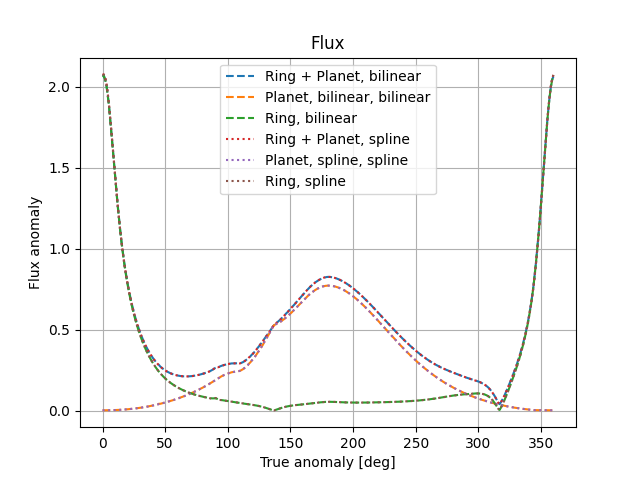

<IPython.core.display.Javascript object>


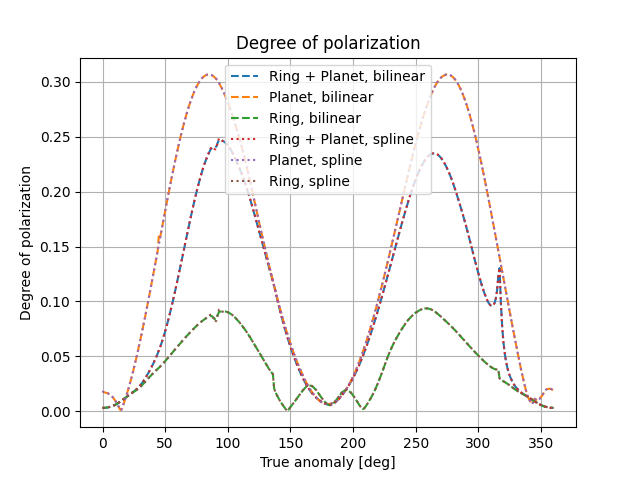

<IPython.core.display.Javascript object>


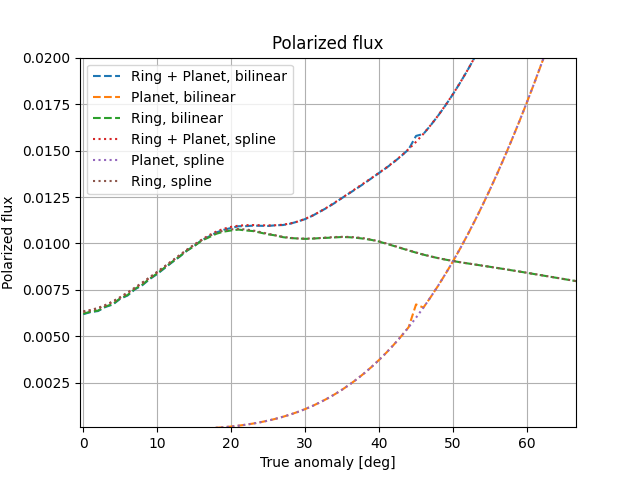

<IPython.core.display.Javascript object>


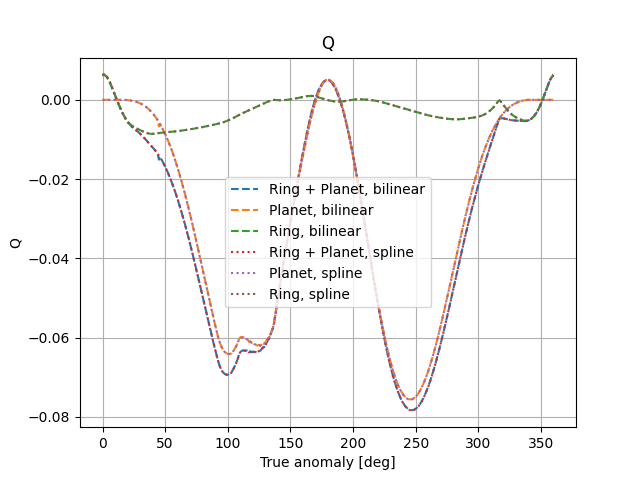

<IPython.core.display.Javascript object>


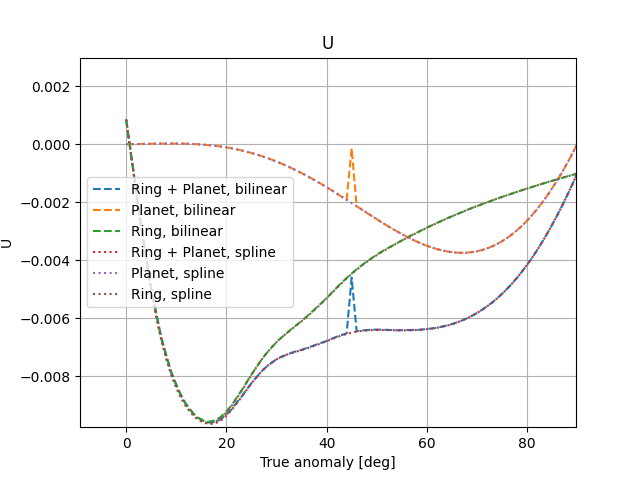

In [7]:
orbit_i = 80 # 90 is edge-on, 0 is face-on #30
ring_i = 10 # 90 is edge-on, 0 is face-on #60
ring_l = 45
names = np.array(["bilinear","spline"])
plot_line = np.array(["--",":"])

fig1=plt.figure()
ax1=fig1.gca()

fig2=plt.figure()
ax2=fig2.gca()

fig3=plt.figure()
ax3=fig3.gca()

fig4=plt.figure()
ax4=fig4.gca()

fig5=plt.figure()
ax5=fig5.gca()
    
for ii, name in enumerate(names):
    data_name = f"/home/allard/Data/Interpolation_test/system_oi{orbit_i}_ri{ring_i}_rl{ring_l}_60gauss_points_{name}.pkl"
    with open(data_name,"rb") as f:
        save_file = pickle.load(f)

    true_anomaly = np.array(save_file["lambda"])
    alpha = np.array(save_file["alpha"])
    Stot = np.array(save_file["Stot"])
    Sp = np.array(save_file["Sp"])
    Sr = np.array(save_file["Sr"])
    Ptot = np.array(save_file["Ptot"])
    Pp = np.array(save_file["Pp"])
    Pr = np.array(save_file["Pr"])

    ax1.plot(true_anomaly,Stot[:,0],plot_line[ii],label=f"Ring + Planet, {name}")
    ax1.plot(true_anomaly,Sp[:,0],plot_line[ii],label=f"Planet, {name}, {name}")
    ax1.plot(true_anomaly,Sr[:,0],plot_line[ii],label=f"Ring, {name}")

    ax2.plot(true_anomaly,Ptot,plot_line[ii],label=f"Ring + Planet, {name}")
    ax2.plot(true_anomaly,Pp,plot_line[ii],label=f"Planet, {name}")
    ax2.plot(true_anomaly,Pr,plot_line[ii],label=f"Ring, {name}")

    ax3.plot(true_anomaly,np.sqrt(Stot[:,1]**2 + Stot[:,2]**2),plot_line[ii],label=f"Ring + Planet, {name}")
    ax3.plot(true_anomaly,np.sqrt(Sp[:,1]**2 + Sp[:,2]**2),plot_line[ii],label=f"Planet, {name}")
    ax3.plot(true_anomaly,np.sqrt(Sr[:,1]**2 + Sr[:,2]**2),plot_line[ii],label=f"Ring, {name}")

    ax4.plot(true_anomaly,Stot[:,1],plot_line[ii],label=f"Ring + Planet, {name}")
    ax4.plot(true_anomaly,Sp[:,1],plot_line[ii],label=f"Planet, {name}")
    ax4.plot(true_anomaly,Sr[:,1],plot_line[ii],label=f"Ring, {name}")

    ax5.plot(true_anomaly,Stot[:,2],plot_line[ii],label=f"Ring + Planet, {name}")
    ax5.plot(true_anomaly,Sp[:,2],plot_line[ii],label=f"Planet, {name}")
    ax5.plot(true_anomaly,Sr[:,2],plot_line[ii],label=f"Ring, {name}")

ax1.set_xlabel("True anomaly [deg]")
ax1.set_ylabel("Flux anomaly")
ax1.set_title("Flux")
ax1.legend()
ax1.grid()

ax2.set_xlabel("True anomaly [deg]")
ax2.set_ylabel("Degree of polarization")
ax2.set_title("Degree of polarization")
ax2.legend()
ax2.grid()

ax3.set_xlabel("True anomaly [deg]")
ax3.set_ylabel("Polarized flux")
ax3.set_title("Polarized flux")
ax3.legend()
ax3.grid()
    
ax4.set_xlabel("True anomaly [deg]")
ax4.set_ylabel("Q")
ax4.set_title("Q")
ax4.legend()
ax4.grid()
    
ax5.set_xlabel("True anomaly [deg]")
ax5.set_ylabel("U")
ax5.set_title("U")
ax5.legend()
ax5.grid()
plt.show()


## Testing normalization

In [16]:
import pryngles.pixx as pixx
gamma, beta_obs, lamb_obs, lamb_star = Util.calcStartingPosition(90,0,0)

pixx_sys = System()
s=pixx_sys.add(kind="Star",physics=dict(radius=Consts.rsun/pixx_sys.ul),optics=dict(limb_coeffs=[0.65]))
p=pixx_sys.add(kind="Planet", primary=s, 
               radius=Consts.rsaturn/pixx_sys.ul,
               orbit=dict(a=1, e=0.0),
               physics=dict(radius=Consts.rsaturn/pixx_sys.ul),
               optics=dict(nspangles=10000))
r=pixx_sys.add(kind="Ring", primary=p,
               physics=dict(fi=1.5, fe=2.25, i=gamma),
               optics=dict(nspangles=1000))

#fou_gasplanet_optical_50.dat , fou_lambert.dat
RP=pixx_sys.ensamble_system(extension=extension, 
                            fname_planet= "./fou_files/Planet/fou_bmsca80.0_asurf1.0.dat",
                            fname_ring="./fou_files/Ring/fou_ring_0_4_0_8_20gaus.dat")
#"./fou_files/Planet/fou_bmsca80.0_asurf1.0.dat" Misc.get_data("fou_lambert.dat")
print(RP.fname_planet)

./fou_files/Planet/fou_bmsca80.0_asurf1.0.dat


In [17]:
lamb_initial = lamb_star
lamb_final = lamb_initial + 360*Consts.deg
lambs = np.linspace(lamb_initial,lamb_final,361)

# Initialise the starting position
RP.changeObserver([lamb_obs,beta_obs])
RP.changeStellarPosition(lamb_initial)
RP._updateGeometricalFactors()
RP._updateIncomingStellarFlux()
RP._updateObservedFacetAreas()

Spsave   = []
Ppsave   = []
alpha    = []

for lamb in lambs:
    RP.changeStellarPosition(lamb)
    print("True anomaly: ", (lamb-lamb_initial)/Consts.deg)
    RP._updateGeometricalFactors()
    RP._updateIncomingStellarFlux()
    RP._updateObservedFacetAreas()
    
    Stotp = np.zeros(3)
    Ptotp = 0
    
    #Planet active facets
    ap=(~((~RP.vp)+(((~RP.ip)*(~RP.np)))))*(RP.ip)

    # Facets that are illuminated through the rings
    apsr=(~((~RP.vp)+(((~RP.ips)*(~RP.np)))))*(RP.ips)

    # Facets that are visible but the line of sight is blocked by the rings
    apso=(~((~RP.vps)+(((~RP.ip)*(~RP.np)))))*(RP.ip)

    # Facets that are both of the above
    apsb=(~((~RP.vps)+(((~RP.ips)*(~RP.np)))))

    cond = ap + apsr + apso + apsb

    if cond.sum() > 0:
        Stokesp = pixx.reflection(cond.sum(), RP.phidiffps[cond], RP.betaps[cond],
                                  abs(RP.etaps[cond]), abs(RP.zetaps[cond]),
                                  RP.nmugsp,RP.nmatp,RP.nfoup,RP.xmup,RP.rfoup,
                                  np.ones(cond.sum())*RP.normp*RP.afp,
                                  RP.behavior["interp_method_planet"]
                                 )
        Sp = Stokesp[:,:-1]
        Stotp = np.sum(Sp,axis=0)/(np.pi*RP.Rp**2)
        # Calculate degree of polarization
        if abs(Stotp[0]) < 1e-6:
            Ptotp = 0.0
        elif abs(Stotp[2]) < 1e-6:
            Ptotp = -Stotp[1]/Stotp[0]
        else:
            Ptotp = np.sqrt(Stotp[1]**2 + Stotp[2]**2)/Stotp[0]

        
    # Save the relevant data
    Spsave   += [Stotp]
    Ppsave   += [Ptotp]
    alpha    += [np.arccos(RP.alphaps)/Consts.deg]
    
true_anomaly = list((lambs-lamb_initial)/Consts.deg)    
save_dict = {"lambda": true_anomaly, "alpha": alpha,
             "Sp": Spsave, "Pp": Ppsave}

# Pickle the data, if file already exists it will be overwritten
with open("/home/allard/Data/Normalization_test/planet_80_full_orbit.pkl", "wb") as f:
    pickle.dump(save_dict, f)

True anomaly:  0.0
True anomaly:  1.0000000000000013
True anomaly:  2.0000000000000027
True anomaly:  3.000000000000004
True anomaly:  4.000000000000005
True anomaly:  4.999999999999995
True anomaly:  5.999999999999996
True anomaly:  6.999999999999997
True anomaly:  7.999999999999998
True anomaly:  9.0
True anomaly:  10.000000000000002
True anomaly:  11.000000000000002
True anomaly:  12.000000000000004
True anomaly:  13.000000000000005
True anomaly:  14.000000000000007
True anomaly:  14.999999999999995
True anomaly:  15.999999999999996
True anomaly:  16.999999999999996
True anomaly:  18.0
True anomaly:  19.0
True anomaly:  20.000000000000004
True anomaly:  21.000000000000004
True anomaly:  21.999999999999993
True anomaly:  23.000000000000007
True anomaly:  23.999999999999996
True anomaly:  24.999999999999996
True anomaly:  25.999999999999996
True anomaly:  27.0
True anomaly:  28.0
True anomaly:  29.000000000000004
True anomaly:  30.000000000000004
True anomaly:  30.999999999999993
True

True anomaly:  358.0
True anomaly:  359.0
True anomaly:  360.0


<IPython.core.display.Javascript object>


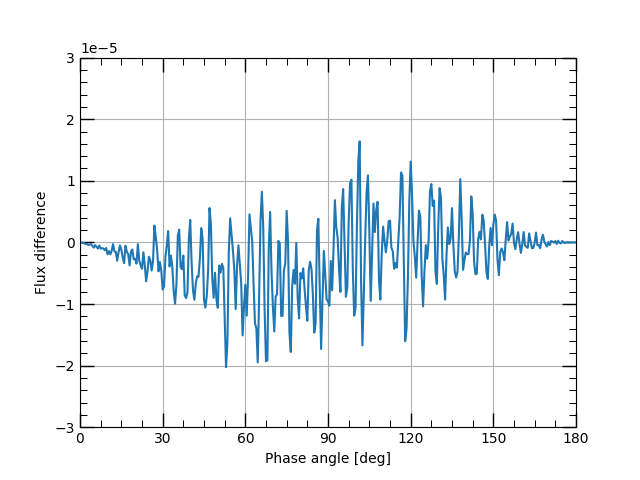

0.6666666400001319


In [41]:
addition = np.array(["_lambertian"])#np.array(["_more_spangles", "_lambertian"]) np.array(["10", "80"])
names = np.array(["Lambertian planet", "Theory"])#np.array(["Gas planet", "Lambertian planet"])
fig1=plt.figure()
ax1=fig1.gca()

for ii,add in enumerate(addition):
    data_name = f"/home/allard/Data/Normalization_test/planet_80{add}.pkl"
    with open(data_name,"rb") as f:
        save_file = pickle.load(f)

    true_anomaly = np.array(save_file["lambda"])
    alpha = np.array(save_file["alpha"])
    Sp = np.array(save_file["Sp"])
    if ii == 0:
        Sp *= 4/np.pi
    #ax1.plot(alpha,Sp[:,0],label=f"Model")

#ax1.plot(alpha,RP.lambertian_test(alpha*Consts.deg),'--',label=f"Theory")
ax1.plot(alpha,RP.lambertian_test(alpha*Consts.deg)-Sp[:,0])
ax1.grid()
efunc.setup(ax1,30,0,180,-3e-5,3e-5,notext=False)
ax1.set_xlabel("Phase angle [deg]")
ax1.set_ylabel("Flux difference")
#ax1.set_title("Flux of the planet")
#ax1.legend()

plt.savefig("/home/allard/Images/Report/difference_model_theory.png",dpi=300)

plt.show()
print(Sp[-1,0])

## Test non directional

In [5]:
# extension = "cpixx"
extension = "pixx"
gamma, beta_obs, lamb_obs, lamb_star = Util.calcStartingPosition(90,0,0)

pixx_sys = System()
s=pixx_sys.add(kind="Star",physics=dict(radius=0.75*Consts.rsun/pixx_sys.ul),optics=dict(limb_coeffs=[0.1103,0.2267]))
p=pixx_sys.add(kind="Planet", primary=s, 
               radius=0.4*Consts.rjupiter/pixx_sys.ul,
               orbit=dict(a=0.07, e=0.0),
               physics=dict(radius=0.4*Consts.rjupiter/pixx_sys.ul),
               optics=dict(nspangles=1000))
r=pixx_sys.add(kind="Ring", primary=p,
               physics=dict(fi=1.5, fe=2.25, i=gamma),
               optics=dict(nspangles=1766))

#fou_gasplanet_optical_50.dat , fou_lambert.dat
RP=pixx_sys.ensamble_system(extension=extension, 
                            fname_planet="./fou_files/Planet/fou_bmsca60.0_asurf1.0.dat",
                            fname_ring="./fou_files/Ring/Mie/fou_file_mie_1.5_020_4500_2.0_0.3_60gaus.dat")
#"./fou_files/Ring/fou_ring_2_0_0_3.dat" "./fou_files/Ring/Mie/fou_file_mie_1.5_020_4500_2.0_0.3_60gaus.dat"
RP.behavior["interp_method_ring"] = "bilinear"#"spline"
RP.behavior["allow_non_uni"] = True
if extension == "cpixx":
    print(RP.fname_ring)
    print(RP.SCr.nmugs)
elif extension == "pixx":
    print(RP.fname_ring)
    print(RP.nmugsr)
    
# extension = "pixx"
print(RP.Nrt)
print(RP.thetap*180/np.pi)
print(RP.thetar*180/np.pi)

./fou_files/Ring/Mie/fou_file_mie_1.5_020_4500_2.0_0.3_60gaus.dat
61
1000
0.15646439990877514
0.35204134473055165


In [13]:
from numpy import linalg as LA

mode = "Second" # "Base" , "First" , "Second"
r = 2.25*0.4*Consts.rjupiter/(0.75*Consts.rsun)# 2.25*Consts.rsaturn/(Consts.rsun)#
d = 0.07*Consts.au/(0.75*Consts.rsun)# 0.1*Consts.au/(Consts.rsun)#

if mode == "Base":
    alpha = 0
    moved = False
else:
    moved = True
    alpha = np.arctan(r/d)
dist = np.sqrt(r**2 + d**2)

N = 1000
frac = d*np.tan(alpha)
n = N/2 + int(frac*N)

p1 = (frac,0,d)
o1 = (0,0,0)
rs = 1
ns = (0,0,-1)

r = np.random.uniform(low=0, high=rs, size=N)  # radius
theta = np.random.uniform(low=0, high=2*np.pi, size=N)  # angle

x = np.sqrt(r) * np.cos(theta)
y = np.sqrt(r) * np.sin(theta)
z = np.zeros(N)
points = np.hstack((np.vstack(x),np.vstack(y),np.vstack(z)))
intensity = Util.limbDarkening(r,1,RP.limb_cs,RP.normlimb)

vecs = points - p1
dists = LA.norm(vecs,axis=1)
nvecs = np.array([(point - p1)/LA.norm((point - p1)) for point in points])
angs = np.inner(nvecs,ns)

if mode == "Second":
    print(np.mean(np.arccos(angs)*180/np.pi))
    illum_angle = angs
    fase_angle = np.pi - alpha
    nstar_obs_rs = nvecs
else:
    nstar_obs_rs = np.array(list(p1/LA.norm(p1))*N).reshape(N,3)
    illum_angle = np.ones(N)*np.cos(alpha)
    fase_angle = np.pi - alpha

# Initialise the starting position
RP.changeObserver([lamb_obs,beta_obs])
RP.changeStellarPosition(lamb_star+alpha)
etaps,zetaps,etars,zetars,phidiffps,phidiffrs,betaps,betars,alphaps,alphars = updateGeometricalFactors(RP,
                                                                                                       illum_angle,
                                                                                                       fase_angle,
                                                                                                       nstar_obs_rs,
                                                                                                       moved)
RP._updateIncomingStellarFlux()
RP._updateObservedFacetAreas()
            
back = False 
if (np.inner(RP.nstar_equ,RP.nr_equ) < 0) ^ (np.inner(RP.nobs_equ,RP.nr_equ) < 0):
    back = True

if back:
    Stokesr = pixx.reflection(len(phidiffrs), phidiffrs, betars,
                              abs(etars), abs(zetars),
                              RP.nmugsr,RP.nmatr,RP.nfour,RP.xmur,RP.tfour,
                              np.ones(len(phidiffrs))*RP.normr*RP.afr,
                              RP.behavior["interp_method_ring"]
                             )
else:
    Stokesr = pixx.reflection(len(phidiffrs), phidiffrs, betars,
                              abs(etars), abs(zetars),
                              RP.nmugsr,RP.nmatr,RP.nfour,RP.xmur,RP.rfour,
                              np.ones(len(phidiffrs))*RP.normr*RP.afr,
                              RP.behavior["interp_method_ring"]
                             )
Sr = Stokesr[:,:-1]
if mode == "Second":
    scaled_S = np.array([S/(4*np.pi*dists[ii]**2) for ii,S in enumerate(Sr)])
    Stotr = np.sum(scaled_S,axis=0)*1e6 
elif mode == "First":
    Stotr = np.sum(Sr,axis=0)/(4*np.pi*dist**2)*1e6 
else:
    Stotr = np.sum(Sr,axis=0)/(4*np.pi*RP.rstar**2)*1e6 

print(Stotr)
print(back)

1.9221503131753392
[3.92043048e+01 2.32965327e-02 5.70600484e-18]
True


In [77]:
## NEW VALUES a = 0.07, fe=2.25, rp = 0.4*rjup, rs = 0.75*rsun, olivine
# With size of star in mind          : [ 2.98259143e+00 -4.32531263e-04 -1.05939605e-19]
# Without size of star but with cond : [ 3.04433214e+00 -1.32070190e-05 -3.23478672e-21]
# Without size of star without cond  : [ 3.04618659 0.         0.        ]

## NEW VALUES a = 0.07, fe=2.25, rp = 0.4*rjup, rs = 0.75*rsun, Mie particles: 20 mu
# With size of star in mind          : [ 3.95930076e+01 2.31526137e-02 5.67075486e-18]  # Random
# Without size of star but with cond : [ 5.30421489e+01 1.20087728e-03 2.94130104e-19]
# Without size of star without cond  : [ 53.59635711  0.          0.        ]

## NEW VALUES a = 1, fe=2.25, rp = 0.4*rjup, rs = 0.75*rsun, Mie particles: 20 mu
# With size of star in mind          : [ 2.62175253e-01 9.68351228e-07 2.37177646e-22]
# Without size of star but with cond : [ 2.62608842e-01 2.88355008e-08 7.06266076e-24]
# Without size of star without cond  : [ 0.26262215 0.         0.        ]


In [81]:
# Olivine
print("remedy1 vs none: ", (3.04433214e+00/3.04618659)*100, (1 - 3.04433214e+00/3.04618659)*100)
print("remedy2 vs none: ", (2.98259143e+00/3.04618659)*100, (1 - 2.98259143e+00/3.04618659)*100)

remedy1 vs none:  99.93912224529883 0.06087775470117185
remedy2 vs none:  97.91230254217618 2.0876974578238228


In [83]:
# Mie
print("remedy1 vs none: ", (5.30421489e+01/53.59635711)*100, (1 - 5.30421489e+01/53.59635711)*100)
print("remedy2 vs none: ", (3.95930076e+01/53.59635711)*100, (1 - 3.95930076e+01/53.59635711)*100)

remedy1 vs none:  98.96595918102689 1.0340408189731143
remedy2 vs none:  73.87257219504708 26.12742780495292


In [112]:
# Mie a=1
print("remedy1 vs none: ", (2.62608842e-01/0.26262215)*100, (1 - 2.62608842e-01/0.26262215)*100)
print("remedy2 vs none: ", (2.62175253e-01/0.26262215)*100, (1 - 2.62175253e-01/0.26262215)*100)

remedy1 vs none:  99.99493264372407 0.0050673562759229185
remedy2 vs none:  99.82983270832258 0.1701672916774144


In [4]:
def updateGeometricalFactors(RP,illum_angle,alpha,nstar_obs_rs,moved):
    """
    Update geometrical factors for facets according to new stellar and observer orientation
    Update: for ALL facets
        etaps,etars: Cosine of stellar incident angle, cos(Lambda_i*)
        zetaps,zetars: Cosine of observer angle, cos(phi_i*)
    Require:
        - _updateStellarPosition
        - _updateObserver
    """       
    #########################
    ### Extra definitions ###
    #########################

    # Location of planetary spangles with respect to planetary scattering plane
    rot_scat = np.arctan2(RP.nstar_obs[1],RP.nstar_obs[0])
    Rz = RP.rotation_matrix_z(rot_scat)       
    rps_scat = np.array([np.matmul(Rz,r) for r in RP.rps_obs])

    # Normal vector of the ring
    nrs_obs = spy.ucrss(RP.rrs_obs[0,:],RP.rrs_obs[1,:])

    # Make sure the normal vector is facing the observer
    if nrs_obs[2] < 0:
        nrs_obs *= -1

    #########################
    ###     Condition     ###
    #########################

    condp = False

    condr = False

    #########################
    ###       Angles      ###
    #########################
    # etars/etaps are incident angles
    # zetars/zetaps are scattered angles
    # alphars/alphaps are phase angles

    # Check condition that the planet is far enough away from the star
    if condp:
        RP.nstar_obs_ps = np.array([spy.unorm(RP.rstar_obs-rps_obs)[0] for rps_obs in RP.rps_obs])
        etaps = np.array([np.inner(RP.nps_obs[ii,:],n_ps) for ii,n_ps in enumerate(RP.nstar_obs_ps)])
        alphaps = RP.nstar_obs_ps[:,2]
    else:
        etaps = np.inner(RP.nstar_obs,RP.nps_obs) # Changed
        alphaps = RP.nstar_obs[2] # cos(alpha) # Phase angle
    
    if condr:
        nstar_obs_rs = np.array([spy.unorm(RP.rstar_obs-rrs_obs)[0] for rrs_obs in RP.rrs_obs])
        etars = illum_angle
        alphars = nstar_obs_rs[:,2]
    else:
        etars = illum_angle
        alphars = alpha # cos(alpha) # Phase angle

    #Scattered angles
    zetaps = RP.nps_obs[:,2]
    zetars = RP.cosio*np.ones(RP.Nrt)

    # Azimuthal difference angle for planet
    t1 = alphaps - zetaps*etaps
    t2 = np.sin(np.arccos(etaps))*np.sin(np.arccos(zetaps))
    t3 = t1/t2
    t3[t3 > 1] = 1.0
    t3[t3 < -1] = -1.0
    t3[abs(t3) < 1e-6] = 0.0

    phidiffps = np.pi - np.arccos(t3)
    phidiffps[abs(t2) <= 1e-9] = 0.0 
    phidiffps[rps_scat[:,1] < 0 ] *= -1 

    # Azimuthal difference angle for ring    
    t1 = alphars - zetars*etars
    t2 = np.sin(np.arccos(etars))*np.sin(np.arccos(zetars))
    t3 = t1/t2
    t3[t3 > 1] = 1.0
    t3[t3 < -1] = -1.0
    t3[abs(t3) < 1e-6] = 0.0
    
    condr = moved
    
    phidiffrs = np.arccos(t3) - np.pi
    if condr:
        for ii,ns_obs_ps in enumerate(nstar_obs_rs):
            ang1 = np.arctan2(ns_obs_ps[1],ns_obs_ps[0])
            ang2 = np.arctan2(nrs_obs[1],nrs_obs[0])
            if nrs_obs[1] >= 0:
                if ang1 > ang2 or ang1 < (ang2-np.pi):
                    phidiffrs[ii] *= -1
            else:
                if ang2 < ang1 and (ang2+np.pi) > ang1:
                    phidiffrs[ii] *= -1
            if abs(t2[ii]) <= 1e-9:
                phidiffrs[ii] = 0.0 
    else:
        ang1 = np.arctan2(RP.nstar_obs[1],RP.nstar_obs[0])
        ang2 = np.arctan2(nrs_obs[1],nrs_obs[0])
        if nrs_obs[1] >= 0:
            if ang1 > ang2 or ang1 < (ang2-np.pi):
                phidiffrs *= -1
        else:
            if ang2 < ang1 and (ang2+np.pi) > ang1:
                phidiffrs *= -1
        phidiffrs[abs(t2) <= 1e-9] = 0.0  

    # Beta angle for planet
    if RP.reference_plane == "Planetary":
        betaps = np.arctan(rps_scat[:,1]/rps_scat[:,0])
        betaps[rps_scat[:,0]*rps_scat[:,1] < 0] += np.pi
    elif RP.reference_plane == "Detector":
        betaps = np.arctan(RP.rps_obs[:,1]/RP.rps_obs[:,0])
        betaps[RP.rps_obs[:,0]*RP.rps_obs[:,1] < 0] += np.pi

    # Beta angle for ring
    if RP.reference_plane == "Planetary":
        nr_obs_nvec = spy.ucrss(nrs_obs,np.array([0,0,1])) # normal vector to obs_nr plane    
        obs_star_nvec = spy.ucrss(RP.nstar_obs,np.array([0,0,1]))
        betars = np.arccos(np.inner(nr_obs_nvec,obs_star_nvec))*np.ones(RP.Nrt)

        # If normal vector is pointing down make sure the beta angle rotates correctly
        if RP.nstar_obs[0] < 0:
            betars *= -1
            betars += np.pi   
    elif RP.reference_plane == "Detector":
        # Calculate angle normal vector makes with the x-axis in the observer frame
        th_nr_x = np.arctan2(nrs_obs[2],nrs_obs[0])

        # Spherical cosine law to calculate beta
        t1 = np.cos(th_nr_x)
        t2 = np.sin(np.arccos(zetars))
        t3 = t1/t2
        t3[t3 > 1] = 1.0
        t3[t3 < -1] = -1.0
        t3[abs(t3) < 1e-6] = 0.0
        betars = np.arccos(t3)
        betars[abs(t2) <= 1e-9] = 0.0 

        # If normal vector of ring is downward still rotate counter clock-wise
        if nrs_obs[1] < 0:
            betars *= -1
            betars += np.pi
            
    return etaps,zetaps,etars,zetars,phidiffps,phidiffrs,betaps,betars,alphaps,alphars